<a href="https://colab.research.google.com/github/sivachakradharnagisetti/My-resume-/blob/main/finalcopymove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 7.1 MB/s eta 0:00:00


100%|██████████| 2.99G/2.99G [00:38<00:00, 82.7MB/s]

Extracting files...


CoMoFoD path: /root/.cache/kagglehub/datasets/mahnoor23/comofod/versions/1


100%|██████████| 14.4M/14.4M [00:00<00:00, 109MB/s] 

Extracting files...


MICC-F220 path: /root/.cache/kagglehub/datasets/mashraffarouk/micc-f220/versions/1


100%|██████████| 147M/147M [00:01<00:00, 118MB/s]

Extracting files...


Splicing dataset path: /root/.cache/kagglehub/datasets/prajnar3/image-forgery-detection-dataset-splicing/versions/1


100%|██████████| 3.74G/3.74G [00:48<00:00, 83.5MB/s]

Extracting files...


MICC-F2000 path: /root/.cache/kagglehub/datasets/manas29/micc-f2000/versions/1
CoMoFoD pairs: 200
MICC-F220 images: 220
Splicing dataset images: 202
MICC-F2000 images: 2000
Total combined samples: 2622


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Epoch 1/25 | loss=0.6224 | acc=0.6648 | prec=0.4938 | rec=0.9244 | f1=0.6437
Epoch 2/25 | loss=0.3581 | acc=0.8819 | prec=0.7778 | rec=0.8953 | f1=0.8324
Epoch 3/25 | loss=0.2801 | acc=0.8705 | prec=0.7430 | rec=0.9244 | f1=0.8238
Epoch 4/25 | loss=0.2512 | acc=0.8800 | prec=0.7583 | rec=0.9302 | f1=0.8355
Epoch 5/25 | loss=0.2304 | acc=0.8876 | prec=0.7678 | rec=0.9419 | f1=0.8460
Epoch 6/25 | loss=0.2138 | acc=0.9010 | prec=0.8030 | rec=0.9244 | f1=0.8595
Epoch 7/25 | loss=0.1874 | acc=0.9200 | prec=0.8385 | rec=0.9360 | f1=0.8846
Epoch 8/25 | loss=0.1962 | acc=0.8057 | prec=0.6336 | rec=0.9651 | f1=0.7650
Epoch 9/25 | loss=0.1905 | acc=0.9181 | prec=0.8377 | rec=0.9302 | f1=0.8815
Epoch 10/25 | loss=0.1778 | acc=0.8971 | prec=0.7864 | rec=0.9419 | f1=0.8571
Epoch 11/25 | loss=0.1699 | acc=0.8895 | prec=0.7689 | rec=0.9477 | f1=0.8490
Epoch 12/25 | loss=0.1630 | acc=0.9314 | prec=0.8579 | rec=0.9477 | f1=0.9006
Epoch 13/25 | loss=0.1642 | acc=0.9276 | prec=0.8641 | rec=0.9244 | f1=0.

Saving forged (22).jpg to forged (22).jpg


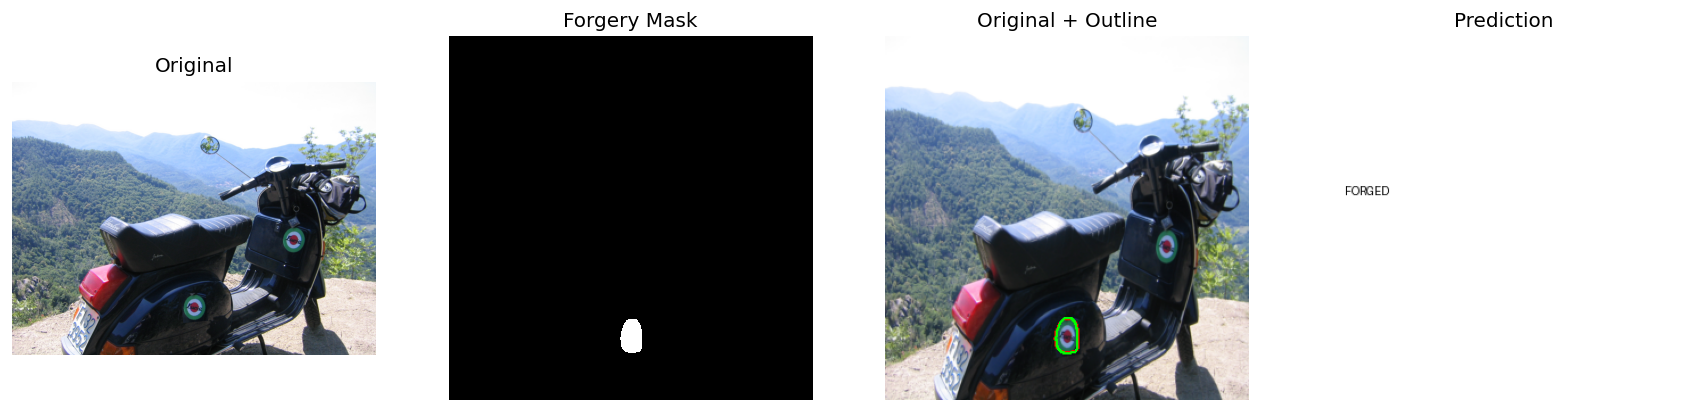

In [1]:
# Colab-ready notebook script: combined CoMoFoD + MICC-F220 + Splicing + MICC-F2000
# Pure CNN (no OpenCV). Uses EfficientNet-B4 encoder with U-Net decoder.

# %% [markdown]
# # Copy-Move Forgery Detection (Combined Datasets)
# This notebook:
# - Downloads CoMoFoD + MICC-F220 + Splicing + MICC-F2000 via kagglehub
# - Builds pixel-wise masks (CoMoFoD masks, MICC rectangles)
# - Trains a U-Net with EfficientNet-B4 encoder
# - Reports image-level confusion matrices (train/test)
# - Supports user upload inference with visualization panels

# %%
# Install dependencies (Colab)
!pip -q install -U kagglehub segmentation-models-pytorch timm scikit-image scikit-learn

# %%
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from skimage import measure
from skimage.filters import threshold_otsu
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import segmentation_models_pytorch as smp
import kagglehub

# %%
# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# %%
# Speed/quality controls
FAST_MODE = False
IMAGE_SIZE = 384 if not FAST_MODE else 256
BATCH_SIZE = 2 if not FAST_MODE else 4
NUM_EPOCHS = 25 if not FAST_MODE else 10

# %%
# Download datasets
comofod_path = kagglehub.dataset_download("mahnoor23/comofod")
print("CoMoFoD path:", comofod_path)
micc_path = kagglehub.dataset_download("mashraffarouk/micc-f220")
print("MICC-F220 path:", micc_path)
splicing_path = kagglehub.dataset_download("prajnar3/image-forgery-detection-dataset-splicing")
print("Splicing dataset path:", splicing_path)
micc2000_path = kagglehub.dataset_download("manas29/micc-f2000")
print("MICC-F2000 path:", micc2000_path)

# %%
# CoMoFoD: collect forged images and binary masks

def find_comofod_pairs(root_dir):
    pairs = []
    for dirpath, _, filenames in os.walk(root_dir):
        for name in filenames:
            if name.lower().endswith(("_f.png", "_f.jpg", "_f.jpeg")):
                forged_path = os.path.join(dirpath, name)
                base = name.replace("_F", "_B").replace("_f", "_B")
                mask_path = os.path.join(dirpath, base)
                if os.path.exists(mask_path):
                    pairs.append((forged_path, mask_path, "comofod"))
    return pairs

# %%
# MICC-F220: build masks from groundtruth rectangles

def load_groundtruth(gt_path):
    gt = {}
    with open(gt_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                name = parts[0]
                x, y, w, h = map(int, parts[1:5])
                gt[name] = (x, y, w, h)
    return gt


def build_micc_pairs(root_dir):
    base_dir = os.path.join(root_dir, "MICC-F220")
    au_dir = os.path.join(base_dir, "Au")
    tu_dir = os.path.join(base_dir, "Tu")
    gt_path = os.path.join(base_dir, "groundtruthDB_220.txt")
    gt = load_groundtruth(gt_path)

    pairs = []
    for name in os.listdir(au_dir):
        if name.lower().endswith((".jpg", ".jpeg", ".png")):
            pairs.append((os.path.join(au_dir, name), None, "micc"))
    for name in os.listdir(tu_dir):
        if name.lower().endswith((".jpg", ".jpeg", ".png")):
            pairs.append((os.path.join(tu_dir, name), gt.get(name), "micc"))
    return pairs


# %%
# Splicing dataset: map tampered images to ground-truth masks

def normalize_stem(name):
    stem = os.path.splitext(name)[0].lower()
    for suffix in ("_gt", "_mask", "_forgery", "_tampered", "_copy", "_copy_move"):
        if stem.endswith(suffix):
            stem = stem[: -len(suffix)]
    return stem


def index_masks_by_stem(root_dir):
    masks = {}
    for dirpath, _, filenames in os.walk(root_dir):
        for name in filenames:
            if name.lower().endswith((".png", ".jpg", ".jpeg")):
                stem = normalize_stem(name)
                masks[stem] = os.path.join(dirpath, name)
    return masks


def build_splicing_pairs(root_dir):
    real_dir = os.path.join(root_dir, "real")
    tampered_dir = os.path.join(root_dir, "tampered")
    gt_dir = os.path.join(root_dir, "ground truth")
    gt_index = index_masks_by_stem(gt_dir)

    pairs = []
    for name in os.listdir(real_dir):
        if name.lower().endswith((".jpg", ".jpeg", ".png")):
            pairs.append((os.path.join(real_dir, name), None, "splicing"))

    for name in os.listdir(tampered_dir):
        if name.lower().endswith((".jpg", ".jpeg", ".png")):
            stem = normalize_stem(name)
            mask_path = gt_index.get(stem)
            if not mask_path:
                for key, path in gt_index.items():
                    if key in stem or stem in key:
                        mask_path = path
                        break
            pairs.append((os.path.join(tampered_dir, name), mask_path, "splicing"))
    return pairs


# %%
# MICC-F2000: generate pseudo-masks by differencing tampered vs. matching originals

def build_micc2000_pairs(root_dir):
    base_dir = os.path.join(root_dir, "MICC-F2000")
    images = {}
    pairs = []

    for name in os.listdir(base_dir):
        if name.lower().endswith((".jpg", ".jpeg", ".png")):
            images[name] = os.path.join(base_dir, name)

    for name, path in images.items():
        lower = name.lower()
        if "tamp" in lower:
            base_name = lower.split("tamp")[0]
            candidates = [
                f"{base_name}.jpg",
                f"{base_name}.jpeg",
                f"{base_name}.png",
                f"{base_name}_scale.jpg",
                f"{base_name}_scale.jpeg",
                f"{base_name}_scale.png",
            ]
            original_path = None
            for cand in candidates:
                for orig_name, orig_path in images.items():
                    if orig_name.lower() == cand:
                        original_path = orig_path
                        break
                if original_path:
                    break
            pairs.append((path, original_path, "micc2000"))
        else:
            if "scale" in lower:
                pairs.append((path, None, "micc2000"))
    return pairs

# %%
comofod_pairs = find_comofod_pairs(comofod_path)
micc_pairs = build_micc_pairs(micc_path)
splicing_pairs = build_splicing_pairs(splicing_path)
micc2000_pairs = build_micc2000_pairs(micc2000_path)
print(f"CoMoFoD pairs: {len(comofod_pairs)}")
print(f"MICC-F220 images: {len(micc_pairs)}")
print(f"Splicing dataset images: {len(splicing_pairs)}")
print(f"MICC-F2000 images: {len(micc2000_pairs)}")

all_pairs = comofod_pairs + micc_pairs + splicing_pairs + micc2000_pairs
print(f"Total combined samples: {len(all_pairs)}")

# %%
# Dataset
class CombinedForgeryDataset(Dataset):
    def __init__(self, pairs, image_size=IMAGE_SIZE, augment=False):
        self.pairs = pairs
        self.image_size = image_size
        self.augment = augment

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_info, source = self.pairs[idx]
        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        if source in {"comofod", "splicing"}:
            if mask_info:
                mask = Image.open(mask_info).convert("L")
            else:
                mask = Image.new("L", (w, h), color=0)
        elif source == "micc":
            mask = Image.new("L", (w, h), color=0)
            if mask_info:
                x, y, rw, rh = mask_info
                draw = ImageDraw.Draw(mask)
                draw.rectangle([x, y, x + rw, y + rh], fill=255)
        elif source == "micc2000":
            mask = Image.new("L", (w, h), color=0)
            if mask_info:
                original = Image.open(mask_info).convert("RGB").resize((w, h), Image.BILINEAR)
                diff = np.abs(np.array(img, dtype=np.int16) - np.array(original, dtype=np.int16))
                diff_gray = diff.mean(axis=2)
                diff_mask = (diff_gray > 20).astype(np.uint8) * 255
                mask = Image.fromarray(diff_mask)
        else:
            mask = Image.new("L", (w, h), color=0)

        if self.augment:
            if random.random() < 0.5:
                img = img.transpose(Image.FLIP_LEFT_RIGHT)
                mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
            if random.random() < 0.5:
                img = img.transpose(Image.FLIP_TOP_BOTTOM)
                mask = mask.transpose(Image.FLIP_TOP_BOTTOM)

        img = img.resize((self.image_size, self.image_size), Image.BILINEAR)
        mask = mask.resize((self.image_size, self.image_size), Image.NEAREST)

        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        mask = TF.to_tensor(mask)
        mask = (mask > 0.5).float()
        return img, mask

# %%
# Train/test split
train_pairs, test_pairs = train_test_split(all_pairs, test_size=0.2, random_state=seed)
train_ds = CombinedForgeryDataset(train_pairs, augment=True)
test_ds = CombinedForgeryDataset(test_pairs, augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# %%
# Model: U-Net with EfficientNet-B4 encoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.Unet(
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
).to(device)

dice_loss = smp.losses.DiceLoss(mode="binary")
bce_loss = torch.nn.BCEWithLogitsLoss()


def combined_loss(logits, targets):
    return dice_loss(logits, targets) + bce_loss(logits, targets)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# %%
# Training helpers

def train_epoch(loader):
    model.train()
    total = 0.0
    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        loss.backward()
        optimizer.step()
        total += loss.item() * imgs.size(0)
    return total / len(loader.dataset)


def eval_image_metrics(loader, threshold=0.5):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).cpu().numpy()
            masks_np = masks.numpy()

            for i in range(preds.shape[0]):
                pred_has_forgery = preds[i].sum() > 0
                true_has_forgery = masks_np[i].sum() > 0
                y_pred.append(int(pred_has_forgery))
                y_true.append(int(true_has_forgery))

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return cm, acc, prec, rec, f1

# %%
# Train with epoch-by-epoch accuracy
num_epochs = NUM_EPOCHS
for epoch in range(num_epochs):
    loss = train_epoch(train_loader)
    _, acc, prec, rec, f1 = eval_image_metrics(test_loader)
    print(
        f"Epoch {epoch + 1}/{num_epochs} | "
        f"loss={loss:.4f} | acc={acc:.4f} | prec={prec:.4f} | rec={rec:.4f} | f1={f1:.4f}"
    )

# %%
# Final image-level confusion matrices
train_cm, train_acc, train_prec, train_rec, train_f1 = eval_image_metrics(train_loader)
test_cm, test_acc, test_prec, test_rec, test_f1 = eval_image_metrics(test_loader)

print("Train Confusion Matrix (image-level):\n", train_cm)
print("Test Confusion Matrix (image-level):\n", test_cm)
print(
    f"Train Metrics: acc={train_acc:.4f} prec={train_prec:.4f} rec={train_rec:.4f} f1={train_f1:.4f}"
)
print(
    f"Test Metrics: acc={test_acc:.4f} prec={test_prec:.4f} rec={test_rec:.4f} f1={test_f1:.4f}"
)

# %%
# Visualization utilities (no OpenCV)

def mask_to_outline(image, mask, color=(255, 0, 0)):
    image = image.copy()
    draw = ImageDraw.Draw(image)
    contours = measure.find_contours(mask, 0.5)
    for contour in contours:
        contour = [(float(c[1]), float(c[0])) for c in contour]
        if len(contour) > 2:
            draw.line(contour, fill=color, width=2)
    return image


def add_dual_outline(image, forged_mask):
    outlined = mask_to_outline(image, forged_mask, color=(255, 0, 0))
    authentic_mask = (forged_mask == 0).astype(np.uint8)
    outlined = mask_to_outline(outlined, authentic_mask, color=(0, 255, 0))
    return outlined

# %%
# Upload and run inference
def binarize_prob_map(prob, fallback_threshold=0.35):
    if np.allclose(prob, prob.flat[0]):
        return prob > fallback_threshold
    try:
        otsu_t = threshold_otsu(prob)
        threshold = max(otsu_t, fallback_threshold)
    except ValueError:
        threshold = fallback_threshold
    return prob > threshold


from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    img = Image.open(filename).convert("RGB")
    orig = img.copy()
    img_resized = img.resize((320, 320), Image.BILINEAR)
    tensor = TF.to_tensor(img_resized)
    tensor = TF.normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    tensor = tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(tensor)
        prob = torch.sigmoid(logits)[0, 0].cpu().numpy()

    mask = binarize_prob_map(prob).astype(np.uint8)
    outline = add_dual_outline(img_resized, mask)

    label_text = "FORGED" if mask.sum() > 0 else "AUTHENTIC"

    # Create a white text panel
    text_panel = Image.new("RGB", (320, 320), color="white")
    draw = ImageDraw.Draw(text_panel)
    font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"
    font_size = 48
    font = ImageFont.load_default()
    if os.path.exists(font_path):
        font = ImageFont.truetype(font_path, font_size)
    draw.text((20, 130), label_text, fill="black", font=font)

    fig, axes = plt.subplots(1, 4, figsize=(18, 5), dpi=120)
    axes[0].imshow(orig)
    axes[0].set_title("Original")
    axes[1].imshow(mask, cmap="gray", interpolation="nearest")
    axes[1].set_title("Forgery Mask")
    axes[2].imshow(outline)
    axes[2].set_title("Original + Outline")
    axes[3].imshow(text_panel)
    axes[3].set_title("Prediction")
    for ax in axes:
        ax.axis("off")
    plt.show()


Saving forged (122).jpg to forged (122).jpg


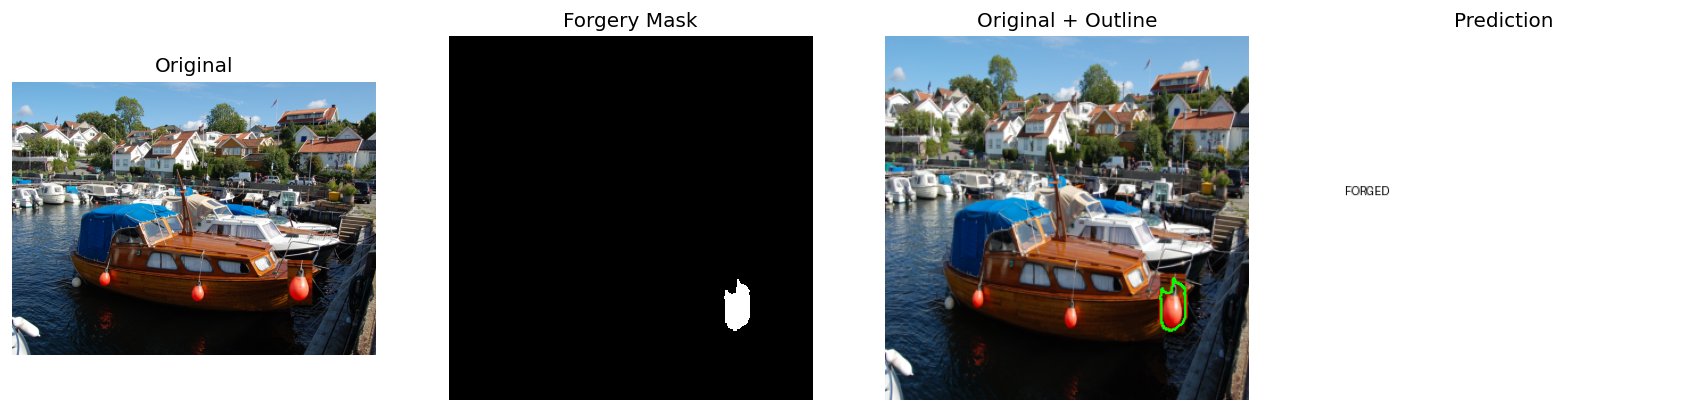

In [2]:
# @title
# %%
# Upload and run inference
def binarize_prob_map(prob, fallback_threshold=0.35):
    if np.allclose(prob, prob.flat[0]):
        return prob > fallback_threshold
    try:
        otsu_t = threshold_otsu(prob)
        threshold = max(otsu_t, fallback_threshold)
    except ValueError:
        threshold = fallback_threshold
    return prob > threshold


from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    img = Image.open(filename).convert("RGB")
    orig = img.copy()
    img_resized = img.resize((320, 320), Image.BILINEAR)
    tensor = TF.to_tensor(img_resized)
    tensor = TF.normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    tensor = tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(tensor)
        prob = torch.sigmoid(logits)[0, 0].cpu().numpy()

    mask = binarize_prob_map(prob).astype(np.uint8)
    outline = add_dual_outline(img_resized, mask)

    label_text = "FORGED" if mask.sum() > 0 else "AUTHENTIC"

    # Create a white text panel
    text_panel = Image.new("RGB", (320, 320), color="white")
    draw = ImageDraw.Draw(text_panel)
    font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"
    font_size = 48
    font = ImageFont.load_default()
    if os.path.exists(font_path):
        font = ImageFont.truetype(font_path, font_size)
    draw.text((20, 130), label_text, fill="black", font=font)

    fig, axes = plt.subplots(1, 4, figsize=(18, 5), dpi=120)
    axes[0].imshow(orig)
    axes[0].set_title("Original")
    axes[1].imshow(mask, cmap="gray", interpolation="nearest")
    axes[1].set_title("Forgery Mask")
    axes[2].imshow(outline)
    axes[2].set_title("Original + Outline")
    axes[3].imshow(text_panel)
    axes[3].set_title("Prediction")
    for ax in axes:
        ax.axis("off")
    plt.show()

Saving 001_F_IB3.png to 001_F_IB3.png


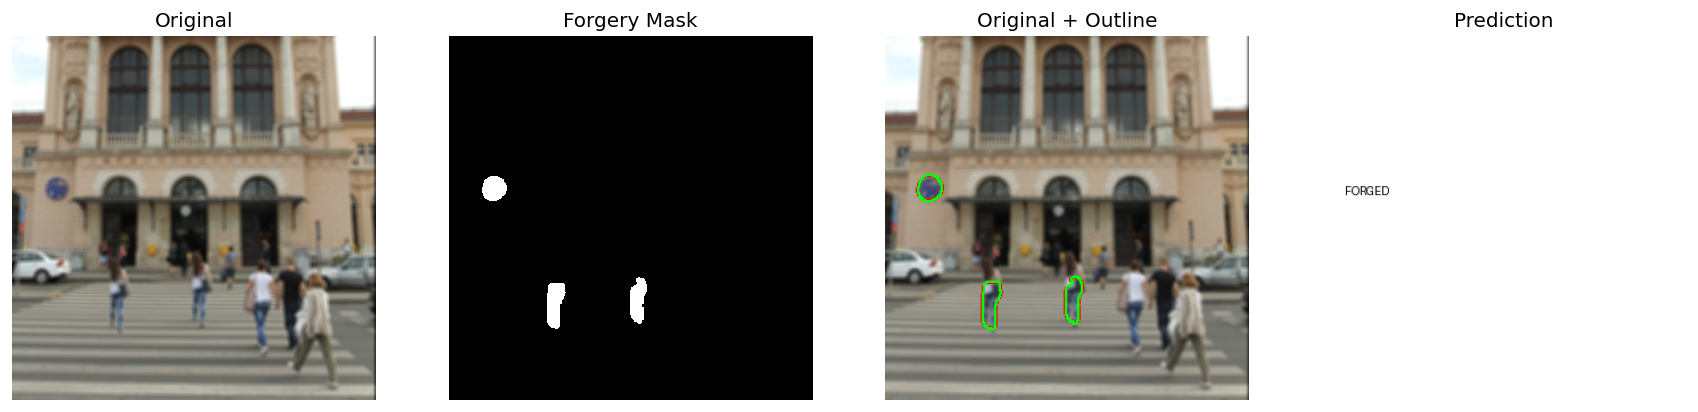

In [3]:
# @title
# %%
# Upload and run inference
def binarize_prob_map(prob, fallback_threshold=0.35):
    if np.allclose(prob, prob.flat[0]):
        return prob > fallback_threshold
    try:
        otsu_t = threshold_otsu(prob)
        threshold = max(otsu_t, fallback_threshold)
    except ValueError:
        threshold = fallback_threshold
    return prob > threshold


from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    img = Image.open(filename).convert("RGB")
    orig = img.copy()
    img_resized = img.resize((320, 320), Image.BILINEAR)
    tensor = TF.to_tensor(img_resized)
    tensor = TF.normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    tensor = tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(tensor)
        prob = torch.sigmoid(logits)[0, 0].cpu().numpy()

    mask = binarize_prob_map(prob).astype(np.uint8)
    outline = add_dual_outline(img_resized, mask)

    label_text = "FORGED" if mask.sum() > 0 else "AUTHENTIC"

    # Create a white text panel
    text_panel = Image.new("RGB", (320, 320), color="white")
    draw = ImageDraw.Draw(text_panel)
    font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"
    font_size = 48
    font = ImageFont.load_default()
    if os.path.exists(font_path):
        font = ImageFont.truetype(font_path, font_size)
    draw.text((20, 130), label_text, fill="black", font=font)

    fig, axes = plt.subplots(1, 4, figsize=(18, 5), dpi=120)
    axes[0].imshow(orig)
    axes[0].set_title("Original")
    axes[1].imshow(mask, cmap="gray", interpolation="nearest")
    axes[1].set_title("Forgery Mask")
    axes[2].imshow(outline)
    axes[2].set_title("Original + Outline")
    axes[3].imshow(text_panel)
    axes[3].set_title("Prediction")
    for ax in axes:
        ax.axis("off")
    plt.show()

Saving forged (71).jpg to forged (71).jpg


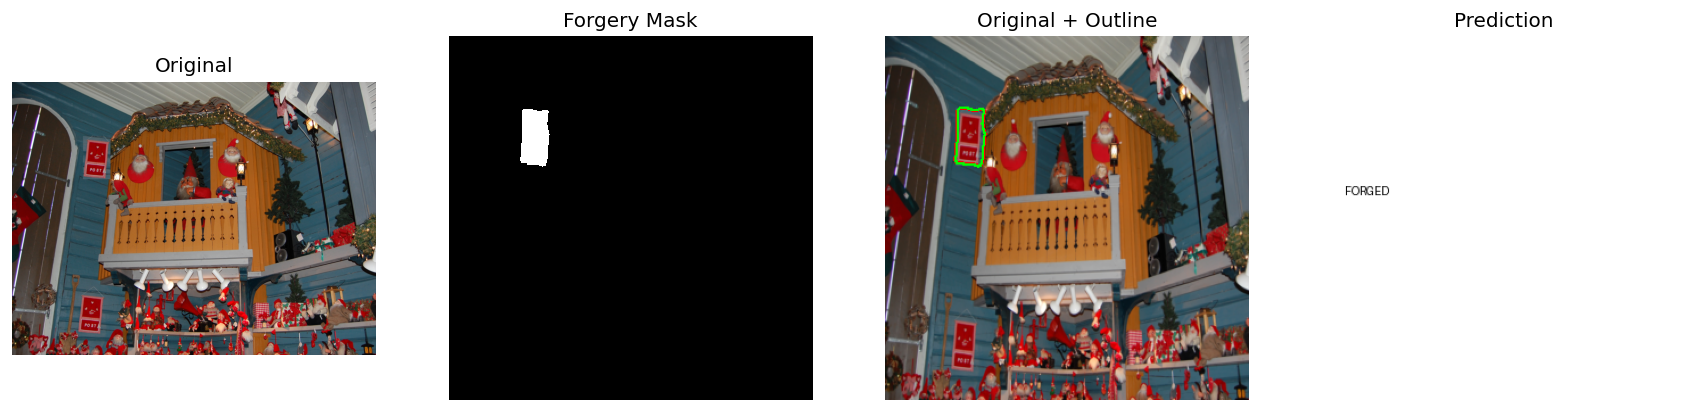

In [6]:
# @title
# %%
# Upload and run inference
def binarize_prob_map(prob, fallback_threshold=0.35):
    if np.allclose(prob, prob.flat[0]):
        return prob > fallback_threshold
    try:
        otsu_t = threshold_otsu(prob)
        threshold = max(otsu_t, fallback_threshold)
    except ValueError:
        threshold = fallback_threshold
    return prob > threshold


from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    img = Image.open(filename).convert("RGB")
    orig = img.copy()
    img_resized = img.resize((320, 320), Image.BILINEAR)
    tensor = TF.to_tensor(img_resized)
    tensor = TF.normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    tensor = tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(tensor)
        prob = torch.sigmoid(logits)[0, 0].cpu().numpy()

    mask = binarize_prob_map(prob).astype(np.uint8)
    outline = add_dual_outline(img_resized, mask)

    label_text = "FORGED" if mask.sum() > 0 else "AUTHENTIC"

    # Create a white text panel
    text_panel = Image.new("RGB", (320, 320), color="white")
    draw = ImageDraw.Draw(text_panel)
    font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"
    font_size = 48
    font = ImageFont.load_default()
    if os.path.exists(font_path):
        font = ImageFont.truetype(font_path, font_size)
    draw.text((20, 130), label_text, fill="black", font=font)

    fig, axes = plt.subplots(1, 4, figsize=(18, 5), dpi=120)
    axes[0].imshow(orig)
    axes[0].set_title("Original")
    axes[1].imshow(mask, cmap="gray", interpolation="nearest")
    axes[1].set_title("Forgery Mask")
    axes[2].imshow(outline)
    axes[2].set_title("Original + Outline")
    axes[3].imshow(text_panel)
    axes[3].set_title("Prediction")
    for ax in axes:
        ax.axis("off")
    plt.show()

Saving 006_F_JC3.jpg to 006_F_JC3.jpg


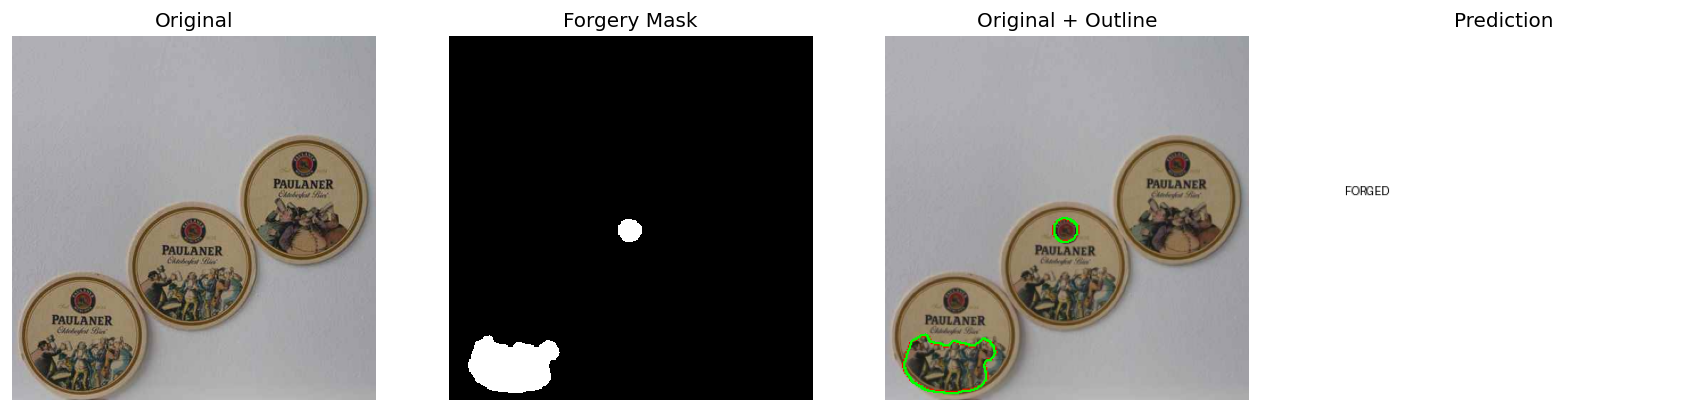

In [10]:
# @title
# %%
# Upload and run inference
def binarize_prob_map(prob, fallback_threshold=0.35):
    if np.allclose(prob, prob.flat[0]):
        return prob > fallback_threshold
    try:
        otsu_t = threshold_otsu(prob)
        threshold = max(otsu_t, fallback_threshold)
    except ValueError:
        threshold = fallback_threshold
    return prob > threshold


from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    img = Image.open(filename).convert("RGB")
    orig = img.copy()
    img_resized = img.resize((320, 320), Image.BILINEAR)
    tensor = TF.to_tensor(img_resized)
    tensor = TF.normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    tensor = tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(tensor)
        prob = torch.sigmoid(logits)[0, 0].cpu().numpy()

    mask = binarize_prob_map(prob).astype(np.uint8)
    outline = add_dual_outline(img_resized, mask)

    label_text = "FORGED" if mask.sum() > 0 else "AUTHENTIC"

    # Create a white text panel
    text_panel = Image.new("RGB", (320, 320), color="white")
    draw = ImageDraw.Draw(text_panel)
    font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"
    font_size = 48
    font = ImageFont.load_default()
    if os.path.exists(font_path):
        font = ImageFont.truetype(font_path, font_size)
    draw.text((20, 130), label_text, fill="black", font=font)

    fig, axes = plt.subplots(1, 4, figsize=(18, 5), dpi=120)
    axes[0].imshow(orig)
    axes[0].set_title("Original")
    axes[1].imshow(mask, cmap="gray", interpolation="nearest")
    axes[1].set_title("Forgery Mask")
    axes[2].imshow(outline)
    axes[2].set_title("Original + Outline")
    axes[3].imshow(text_panel)
    axes[3].set_title("Prediction")
    for ax in axes:
        ax.axis("off")
    plt.show()

Saving 009_F_CA3.png to 009_F_CA3.png


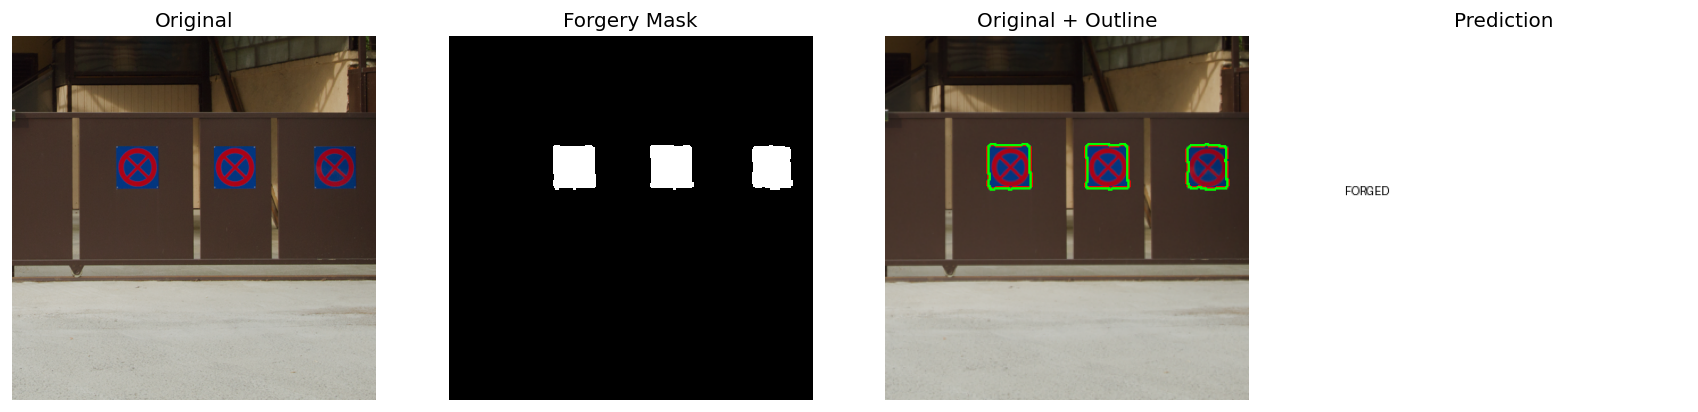

In [11]:
# @title
# %%
# Upload and run inference
def binarize_prob_map(prob, fallback_threshold=0.35):
    if np.allclose(prob, prob.flat[0]):
        return prob > fallback_threshold
    try:
        otsu_t = threshold_otsu(prob)
        threshold = max(otsu_t, fallback_threshold)
    except ValueError:
        threshold = fallback_threshold
    return prob > threshold


from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    img = Image.open(filename).convert("RGB")
    orig = img.copy()
    img_resized = img.resize((320, 320), Image.BILINEAR)
    tensor = TF.to_tensor(img_resized)
    tensor = TF.normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    tensor = tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(tensor)
        prob = torch.sigmoid(logits)[0, 0].cpu().numpy()

    mask = binarize_prob_map(prob).astype(np.uint8)
    outline = add_dual_outline(img_resized, mask)

    label_text = "FORGED" if mask.sum() > 0 else "AUTHENTIC"

    # Create a white text panel
    text_panel = Image.new("RGB", (320, 320), color="white")
    draw = ImageDraw.Draw(text_panel)
    font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"
    font_size = 48
    font = ImageFont.load_default()
    if os.path.exists(font_path):
        font = ImageFont.truetype(font_path, font_size)
    draw.text((20, 130), label_text, fill="black", font=font)

    fig, axes = plt.subplots(1, 4, figsize=(18, 5), dpi=120)
    axes[0].imshow(orig)
    axes[0].set_title("Original")
    axes[1].imshow(mask, cmap="gray", interpolation="nearest")
    axes[1].set_title("Forgery Mask")
    axes[2].imshow(outline)
    axes[2].set_title("Original + Outline")
    axes[3].imshow(text_panel)
    axes[3].set_title("Prediction")
    for ax in axes:
        ax.axis("off")
    plt.show()

Saving 014_F_IB1.png to 014_F_IB1.png


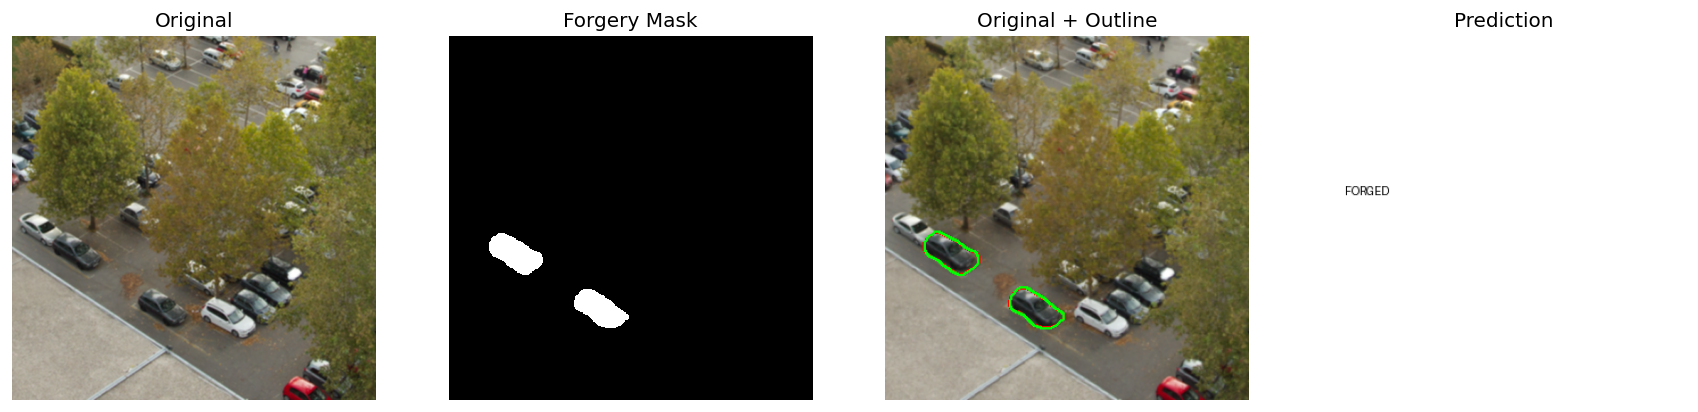

In [13]:
# @title
# %%
# Upload and run inference
def binarize_prob_map(prob, fallback_threshold=0.35):
    if np.allclose(prob, prob.flat[0]):
        return prob > fallback_threshold
    try:
        otsu_t = threshold_otsu(prob)
        threshold = max(otsu_t, fallback_threshold)
    except ValueError:
        threshold = fallback_threshold
    return prob > threshold


from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    img = Image.open(filename).convert("RGB")
    orig = img.copy()
    img_resized = img.resize((320, 320), Image.BILINEAR)
    tensor = TF.to_tensor(img_resized)
    tensor = TF.normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    tensor = tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(tensor)
        prob = torch.sigmoid(logits)[0, 0].cpu().numpy()

    mask = binarize_prob_map(prob).astype(np.uint8)
    outline = add_dual_outline(img_resized, mask)

    label_text = "FORGED" if mask.sum() > 0 else "AUTHENTIC"

    # Create a white text panel
    text_panel = Image.new("RGB", (320, 320), color="white")
    draw = ImageDraw.Draw(text_panel)
    font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"
    font_size = 48
    font = ImageFont.load_default()
    if os.path.exists(font_path):
        font = ImageFont.truetype(font_path, font_size)
    draw.text((20, 130), label_text, fill="black", font=font)

    fig, axes = plt.subplots(1, 4, figsize=(18, 5), dpi=120)
    axes[0].imshow(orig)
    axes[0].set_title("Original")
    axes[1].imshow(mask, cmap="gray", interpolation="nearest")
    axes[1].set_title("Forgery Mask")
    axes[2].imshow(outline)
    axes[2].set_title("Original + Outline")
    axes[3].imshow(text_panel)
    axes[3].set_title("Prediction")
    for ax in axes:
        ax.axis("off")
    plt.show()

Saving 027_F_NA3.png to 027_F_NA3.png


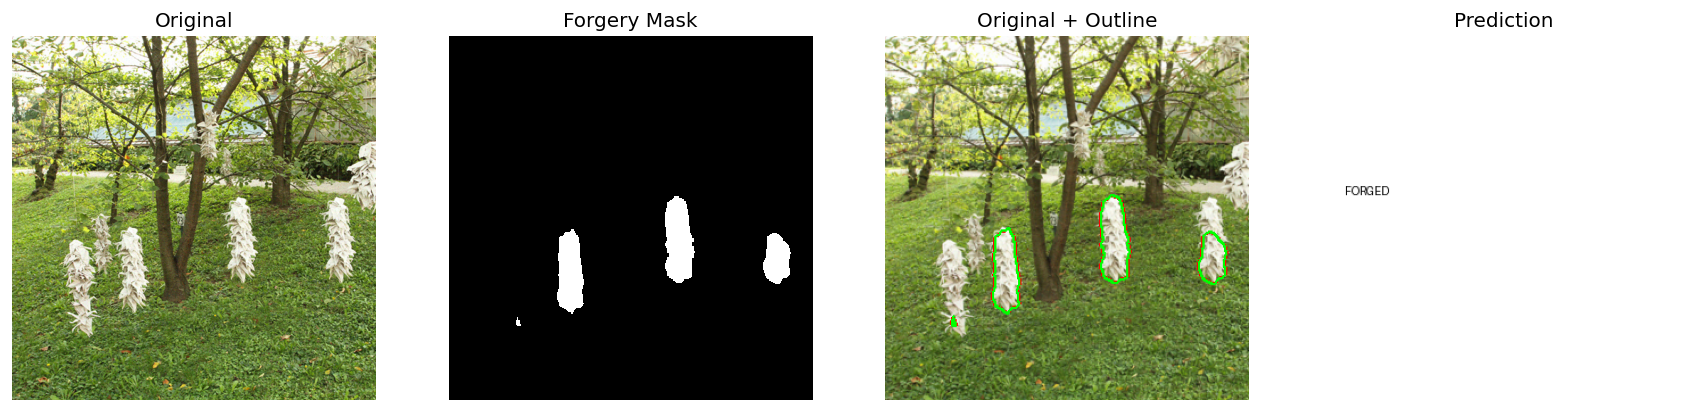

In [14]:
# @title
# %%
# Upload and run inference
def binarize_prob_map(prob, fallback_threshold=0.35):
    if np.allclose(prob, prob.flat[0]):
        return prob > fallback_threshold
    try:
        otsu_t = threshold_otsu(prob)
        threshold = max(otsu_t, fallback_threshold)
    except ValueError:
        threshold = fallback_threshold
    return prob > threshold


from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    img = Image.open(filename).convert("RGB")
    orig = img.copy()
    img_resized = img.resize((320, 320), Image.BILINEAR)
    tensor = TF.to_tensor(img_resized)
    tensor = TF.normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    tensor = tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(tensor)
        prob = torch.sigmoid(logits)[0, 0].cpu().numpy()

    mask = binarize_prob_map(prob).astype(np.uint8)
    outline = add_dual_outline(img_resized, mask)

    label_text = "FORGED" if mask.sum() > 0 else "AUTHENTIC"

    # Create a white text panel
    text_panel = Image.new("RGB", (320, 320), color="white")
    draw = ImageDraw.Draw(text_panel)
    font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"
    font_size = 48
    font = ImageFont.load_default()
    if os.path.exists(font_path):
        font = ImageFont.truetype(font_path, font_size)
    draw.text((20, 130), label_text, fill="black", font=font)

    fig, axes = plt.subplots(1, 4, figsize=(18, 5), dpi=120)
    axes[0].imshow(orig)
    axes[0].set_title("Original")
    axes[1].imshow(mask, cmap="gray", interpolation="nearest")
    axes[1].set_title("Forgery Mask")
    axes[2].imshow(outline)
    axes[2].set_title("Original + Outline")
    axes[3].imshow(text_panel)
    axes[3].set_title("Prediction")
    for ax in axes:
        ax.axis("off")
    plt.show()

Saving au_025.jpeg to au_025.jpeg


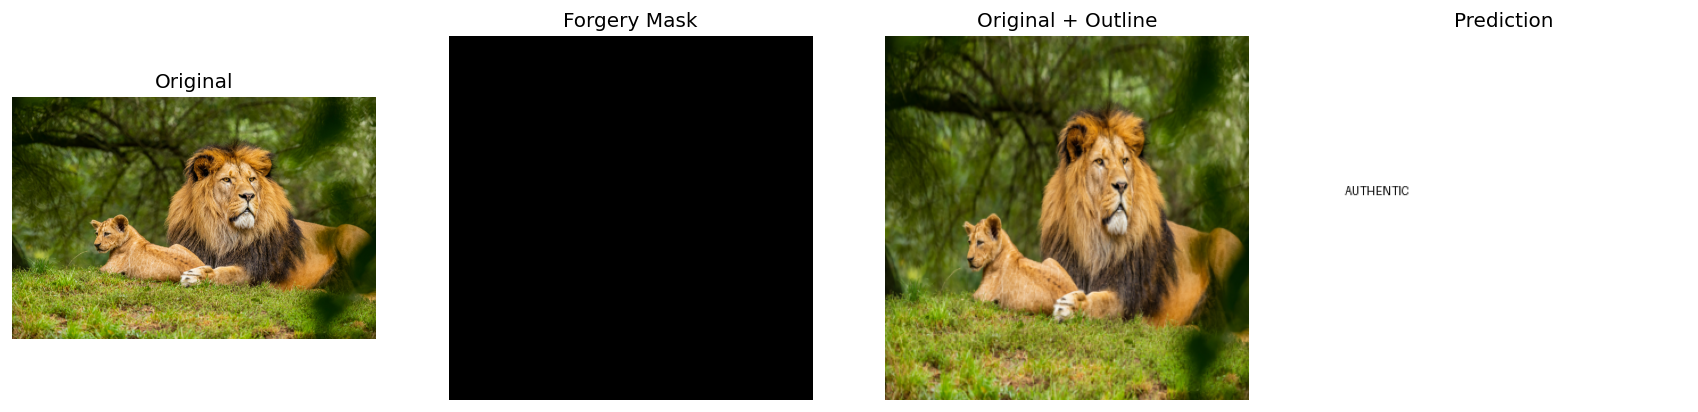

In [15]:
# @title
# %%
# Upload and run inference
def binarize_prob_map(prob, fallback_threshold=0.35):
    if np.allclose(prob, prob.flat[0]):
        return prob > fallback_threshold
    try:
        otsu_t = threshold_otsu(prob)
        threshold = max(otsu_t, fallback_threshold)
    except ValueError:
        threshold = fallback_threshold
    return prob > threshold


from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    img = Image.open(filename).convert("RGB")
    orig = img.copy()
    img_resized = img.resize((320, 320), Image.BILINEAR)
    tensor = TF.to_tensor(img_resized)
    tensor = TF.normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    tensor = tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(tensor)
        prob = torch.sigmoid(logits)[0, 0].cpu().numpy()

    mask = binarize_prob_map(prob).astype(np.uint8)
    outline = add_dual_outline(img_resized, mask)

    label_text = "FORGED" if mask.sum() > 0 else "AUTHENTIC"

    # Create a white text panel
    text_panel = Image.new("RGB", (320, 320), color="white")
    draw = ImageDraw.Draw(text_panel)
    font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"
    font_size = 48
    font = ImageFont.load_default()
    if os.path.exists(font_path):
        font = ImageFont.truetype(font_path, font_size)
    draw.text((20, 130), label_text, fill="black", font=font)

    fig, axes = plt.subplots(1, 4, figsize=(18, 5), dpi=120)
    axes[0].imshow(orig)
    axes[0].set_title("Original")
    axes[1].imshow(mask, cmap="gray", interpolation="nearest")
    axes[1].set_title("Forgery Mask")
    axes[2].imshow(outline)
    axes[2].set_title("Original + Outline")
    axes[3].imshow(text_panel)
    axes[3].set_title("Prediction")
    for ax in axes:
        ax.axis("off")
    plt.show()

Saving forged (42).jpg to forged (42).jpg


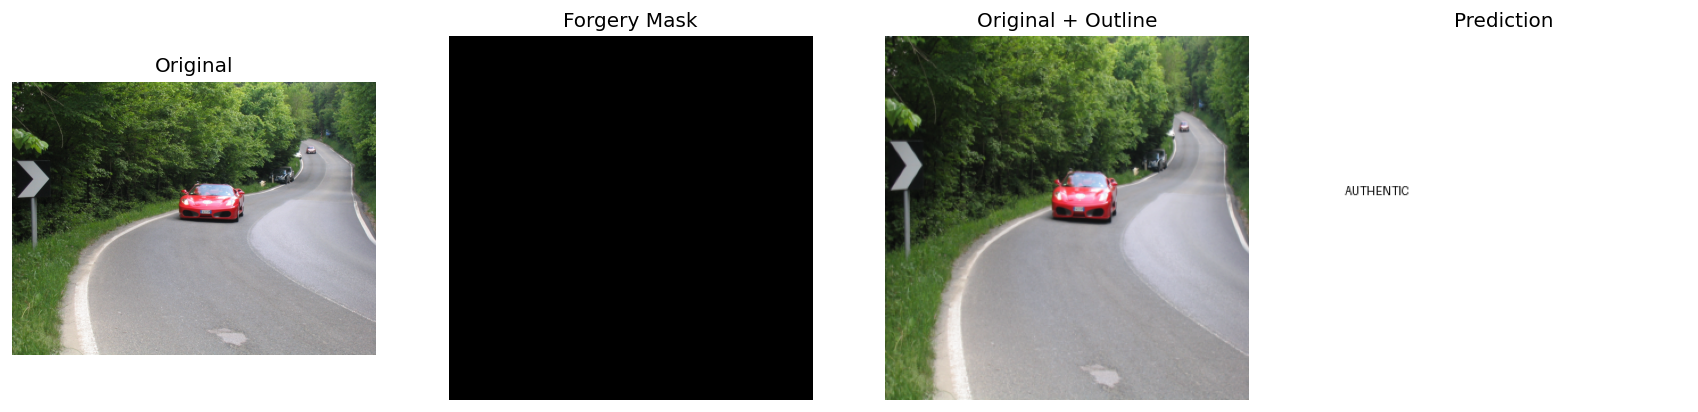

In [17]:
# @title
# %%
# Upload and run inference
def binarize_prob_map(prob, fallback_threshold=0.35):
    if np.allclose(prob, prob.flat[0]):
        return prob > fallback_threshold
    try:
        otsu_t = threshold_otsu(prob)
        threshold = max(otsu_t, fallback_threshold)
    except ValueError:
        threshold = fallback_threshold
    return prob > threshold


from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    img = Image.open(filename).convert("RGB")
    orig = img.copy()
    img_resized = img.resize((320, 320), Image.BILINEAR)
    tensor = TF.to_tensor(img_resized)
    tensor = TF.normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    tensor = tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(tensor)
        prob = torch.sigmoid(logits)[0, 0].cpu().numpy()

    mask = binarize_prob_map(prob).astype(np.uint8)
    outline = add_dual_outline(img_resized, mask)

    label_text = "FORGED" if mask.sum() > 0 else "AUTHENTIC"

    # Create a white text panel
    text_panel = Image.new("RGB", (320, 320), color="white")
    draw = ImageDraw.Draw(text_panel)
    font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"
    font_size = 48
    font = ImageFont.load_default()
    if os.path.exists(font_path):
        font = ImageFont.truetype(font_path, font_size)
    draw.text((20, 130), label_text, fill="black", font=font)

    fig, axes = plt.subplots(1, 4, figsize=(18, 5), dpi=120)
    axes[0].imshow(orig)
    axes[0].set_title("Original")
    axes[1].imshow(mask, cmap="gray", interpolation="nearest")
    axes[1].set_title("Forgery Mask")
    axes[2].imshow(outline)
    axes[2].set_title("Original + Outline")
    axes[3].imshow(text_panel)
    axes[3].set_title("Prediction")
    for ax in axes:
        ax.axis("off")
    plt.show()